<a href="https://colab.research.google.com/github/salmakhale/DL-computer-vision/blob/main/VGG16_XRay_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to Google Drive to access Dataset

In [ ]:
# Connect with kaggle

!pip install kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the data set from kaggle

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


100% 2.29G/2.29G [00:29<00:00, 36.8MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.0MB/s]


In [ ]:
# Unzip the data set file

!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### Import all dependencies

In [ ]:
import keras
from keras.models import *
from keras.preprocessing import *  #For Data prerpocessing before making my own Model
from keras.layers import *
import PIL
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
# import BatchNormalization
from keras.layers.normalization import BatchNormalization
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16,VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

CT Scan Dataset 1 Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
#using Rescale only in Testing
test_datagen=ImageDataGenerator(
    rescale = 1./255
)
valid_datagen = ImageDataGenerator(
    rescale=1./255
)

training_set = train_datagen.flow_from_directory(
     r'/content/chest_xray/train',
     target_size=(224, 224),
     batch_size=32,
     class_mode='categorical')

test_set = test_datagen.flow_from_directory(
    r'/content/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

#define paths
covid_path = '/content/chest_xray/train/NORMAL'
noncovid_path = '/content/chest_xray/train/PNEUMONIA'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
#covid_files = files.extend(glob('*.png'))
noncovid_files = glob(noncovid_path + '/*')
#files.extend(glob('*.png'))

In [ ]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))


First 5 Covid Files:  ['/content/chest_xray/train/NORMAL/IM-0622-0001-0002.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0666-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-0932-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-1257-0001.jpeg', '/content/chest_xray/train/NORMAL/IM-0503-0001.jpeg']
Total Count:  1341
First 5 NonCovid Files:  ['/content/chest_xray/train/PNEUMONIA/person460_virus_948.jpeg', '/content/chest_xray/train/PNEUMONIA/person1303_bacteria_3267.jpeg', '/content/chest_xray/train/PNEUMONIA/person1232_virus_2089.jpeg', '/content/chest_xray/train/PNEUMONIA/person342_virus_701.jpeg', '/content/chest_xray/train/PNEUMONIA/person441_virus_897.jpeg']
Total Count:  3875


### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualize First 40 Images from Data set

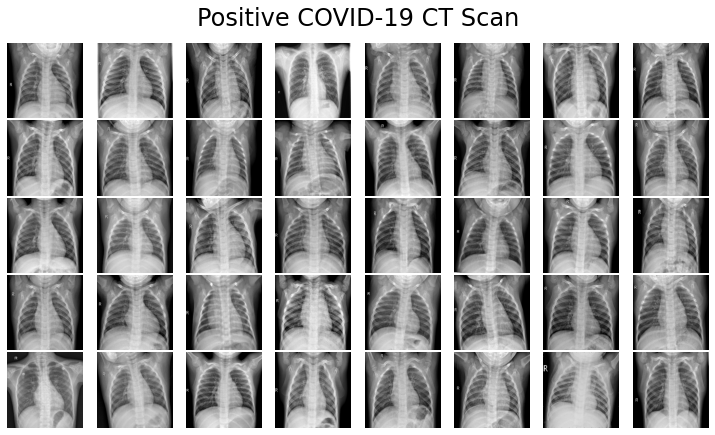

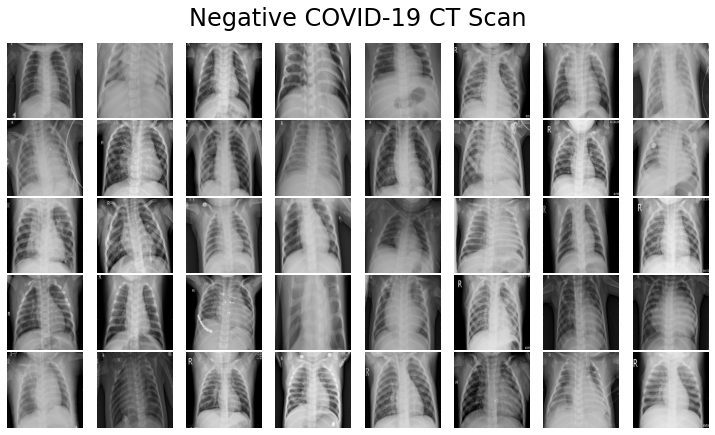

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

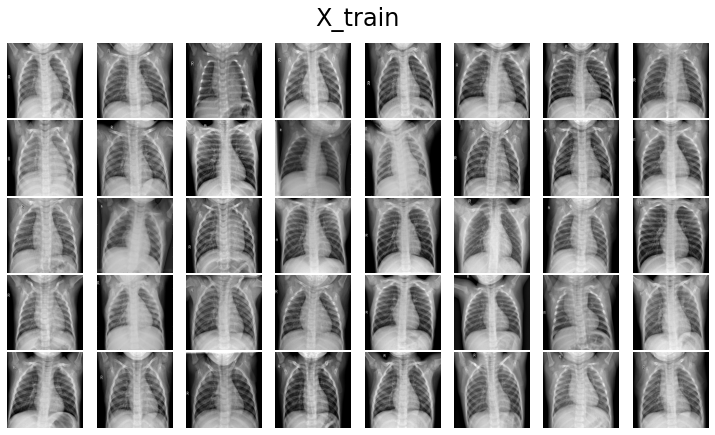

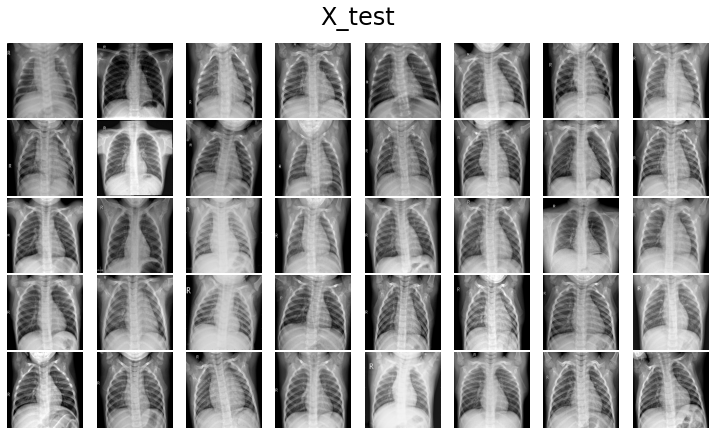

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [ ]:
# Building Model
vggModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
#outputs = Dropout(0.5)(outputs)
outputs = Dense(4096, activation="relu")(outputs)
#outputs = Dense(4096, activation="relu")(outputs)
outputs = Dense(1000, activation="relu")(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
)

trial = '5'

In [ ]:
# Visualize Model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [ ]:
# training config:
epochs = 100
batch_size = 32

history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/100
130/130 [==============================] - 93s 441ms/step - loss: 10.9278 - accuracy: 0.8797 - val_loss: 2.1216 - val_accuracy: 0.9186
Epoch 2/100
130/130 [==============================] - 55s 420ms/step - loss: 0.5893 - accuracy: 0.9394 - val_loss: 0.2463 - val_accuracy: 0.9492
Epoch 3/100
130/130 [==============================] - 52s 396ms/step - loss: 0.1850 - accuracy: 0.9521 - val_loss: 0.2142 - val_accuracy: 0.9502
Epoch 4/100
130/130 [==============================] - 51s 389ms/step - loss: 0.1767 - accuracy: 0.9554 - val_loss: 0.1590 - val_accuracy: 0.9435
Epoch 5/100
130/130 [==============================] - 51s 388ms/step - loss: 0.1349 - accuracy: 0.9595 - val_loss: 0.1090 - val_accuracy: 0.9531
Epoch 6/100
130/130 [==============================] - 51s 388ms/step - loss: 0.1160 - accuracy: 0.9609 - val_loss: 0.2110 - val_accuracy: 0.9483
Epoch 7/100
130/130 [==============================] - 51s 388ms/step - loss: 0.0945 - accuracy: 0.9686 - val_loss: 0.1181 

In [ ]:
# Save Model and Weights
drive_path = '/content/MyDrive/MyDrive/NTI_AI_2021/CNN_Project/'

model.save(drive_path + 'vgg16_ct_'+trial+'.h5')


In [ ]:
# Load saved model
drive_path = '/content/MyDrive/MyDrive/NTI_AI_2021/CNN_Project/'
model = load_model(drive_path + 'vgg16_ct_'+trial+'.h5')

### **Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
y_pred

array([[7.93118969e-18, 1.00000000e+00],
       [5.55618769e-08, 1.00000000e+00],
       [5.82254988e-14, 1.00000000e+00],
       ...,
       [1.00000000e+00, 2.04767900e-08],
       [9.99999285e-01, 7.14419059e-07],
       [9.99987960e-01, 1.20854775e-05]], dtype=float32)

### Visulaizing First 10 predictions

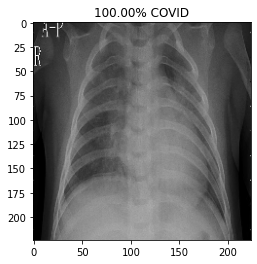

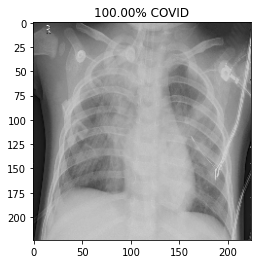

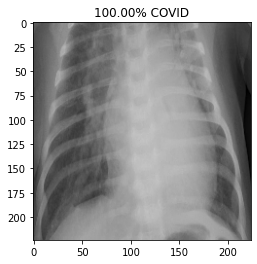

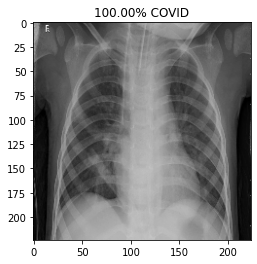

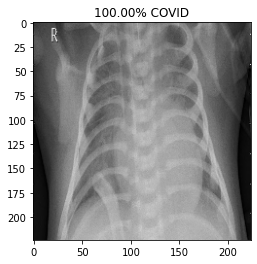

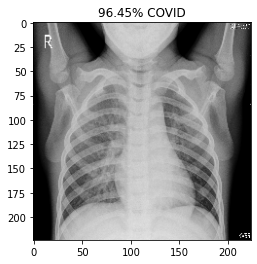

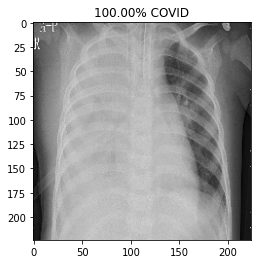

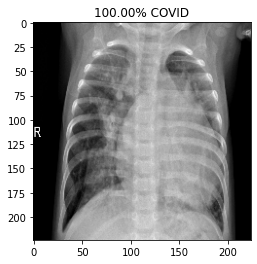

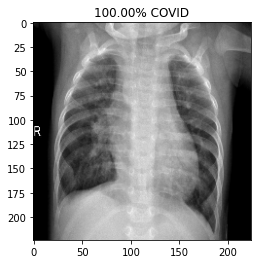

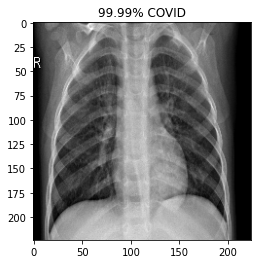

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### **Accuracy and Loss Plots**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

In [ ]:
model.evaluate(X_test,y_test, verbose=1)

33/33 [==============================] - 4s 129ms/step - loss: 0.1389 - accuracy: 0.9607


[0.13887625932693481, 0.9607279896736145]

In [ ]:
test_loss,test_acc=model.evaluate(X_test,y_test)
print("test_set :{}   test_acc :{}".format(test_loss,test_acc))

33/33 [==============================] - 4s 132ms/step - loss: 0.1389 - accuracy: 0.9607
test_set :0.13887625932693481   test_acc :0.9607279896736145


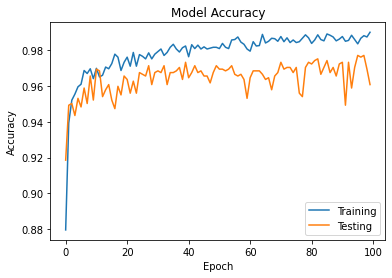

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
#plt.savefig(drive_path + 'vgg16_ct_'+trial+'_accuracy.png')
plt.show()


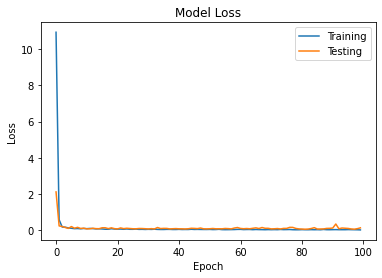

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
#plt.savefig(drive_path + 'vgg16_ct_'+trial+'_loss.png')
plt.show()

In [ ]:
history.history['val_accuracy'][99]

0.9607279896736145

### Plot ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

sns.heatmap(df, cmap="YlGnBu")
sns.heatmap(df, cmap="Blues")
sns.heatmap(df, cmap="BuPu")
sns.heatmap(df, cmap="Greens")

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='Blues',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))